# TensorBoard のスカラー: Keras でトレーニングメトリックをログする

https://www.tensorflow.org/tensorboard/scalars_and_keras?hl=ja

## 概要

機械学習には、損失などの主要なメトリック、そしてトレーニングが進むにつれそれらがどのように変化するかを理解することが必ず伴います。こういったメトリックは、過適合が発生していないか、不要に長くトレーニングしていないかなどを理解する上で役立ちます。そのため、モデルのデバッグや改善を行いやすくするために、トレーニングの実行から得られるメトリックを比較すると良いでしょう。

TensorBoard の Scalars ダッシュボードでは、単純な API を使用して簡単にメトリックを視覚化することができます。このチュートリアルでは、非常に基本的な例を使って、Keras モデルを開発する際に TensorBoard でこれらの API を使用する方法を説明します。Keras TensorBoard コールバックと TensorFlow Summary API を使用してデフォルトとカスタムのスカラーを視覚化する方法を学習します。

## セットアップ

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

ターミナルからtensorboard 起動

cd /Users/kaoru/opt/anaconda3/envs/py37_Kaggle_GreatBarrierReef/lib/python3.7/site-packages/tensorboard

python main.py --logdir=/Users/kaoru/Documents/Python_Tensorflow2.0_Guidance/logs

tensorboard 起動に成功したら、下記にアクセス  
http://localhost:6006/

In [2]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

import numpy as np

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.7.0


## 簡単な回帰用データをセットアップする

これから Keras を使用して回帰を計算し、データセットペアにおける最適な適合線を見つけたいと思います。（この種の問題でニューラルネットワークと勾配降下を使用するのはやり過ぎではありますが、例を理解しやすくなります。）

TensorBoard を使用して、エポック間でトレーニングとテストの損失がどのように変化するのかを観測します。時間の経過とともにトレーニングとテストの損失が下降して安定化する様子を確認してください。

まず、おおまかに線 y = 0.5x + 2 に沿って 1000 個のデータポイントを生成し、それらをトレーニングセットとテストセットに分割します。ここでは、ニューラルネットワークがこの関係を学習することを目標とします。

In [3]:
data_size = 1000
# 80% of the data is for training.
train_pct = 0.8

train_size = int(data_size * train_pct)

# Create some input data between -1 and 1 and randomize it.
x = np.linspace(-1, 1, data_size)
np.random.shuffle(x)

# Generate the output data.
# y = 0.5x + 2 + noise
y = 0.5 * x + 2 + np.random.normal(0, 0.05, (data_size, ))

# Split into test and train pairs.
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

In [4]:
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (800,)
y_train.shape =  (800,)
x_test.shape =  (200,)
y_test.shape =  (200,)


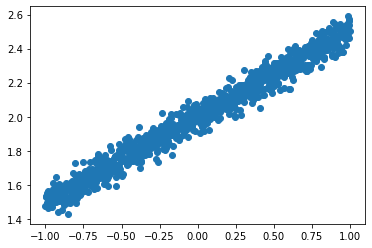

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.show()

/Users/kaoru/opt/anaconda3/envs/py37_Kaggle_GreatBarrierReef/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


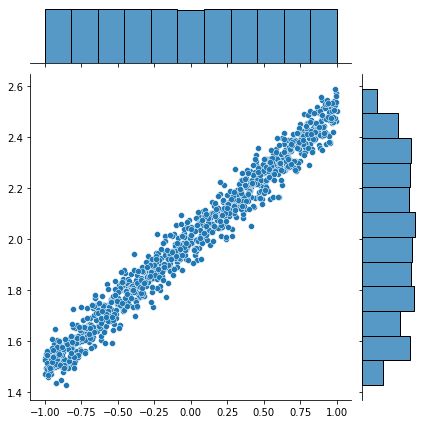

In [6]:
import seaborn as sns
 
# 散布図
sns.jointplot(x, y)
plt.show()


## モデルをトレーニングして損失をログする

モデルの定義、トレーニング、および評価の準備が整いました。

トレーニングしながら損失スカラーをログするには、次のように行います。

1. Keras TensorBoard コールバックを作成します。
2. ログディレクトリを指定します。
3. TensorBoard コールバックを Keras の Model.fit() に渡します。

TensorBoard は、ログディレクトリ階層からログデータを読み取ります。このノートブックでは、ルートログディレクトリは logs/scalars で、その後にタイムスタンプ付きのサブディレクトリが続きます。タイムスタンプがサブディレクトリに付加されることで、TensorBoard を使用してモデルでイテレーションを行う際に、トレーニングセットを簡単に識別して選択することができます。

In [7]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = keras.models.Sequential([
    keras.layers.Dense(16, input_dim=1),
    keras.layers.Dense(1),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=keras.optimizers.SGD(lr=0.2),
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    x_train, # input
    y_train, # output
    batch_size=train_size,
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))

2021-12-30 12:31:53.986822: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/kaoru/opt/anaconda3/envs/py37_Kaggle_GreatBarrierReef/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Training ... With default parameters, this takes less than 10 seconds.
Average test loss:  0.05631260013440624


もう一度 TensorBoard を確認しましょう。

python main.py --logdir=/Users/kaoru/Documents/Python_Tensorflow2.0_Guidance/logs/scalars

In [8]:
# 下記直接起動できない
# %tensorboard --logdir logs/scalars

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

左側の「Runs」セレクタを使用すると、<timestamp>/metrics 実行が 1 つあります。この実行を選択すると「learning rate（学習率）」グラフが表示され、この実行における学習率の進行を確認することができます。

また、この実行のトレーニングと検証の損失曲線を、以前の実行のものと比較することも可能です。

このモデルの出来栄えはどうでしょうか。

In [9]:
print(model.predict([60, 25, 2]))

[[32.06118  ]
 [14.524253 ]
 [ 2.9999855]]
